In [32]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import re
import multiprocessing
from copy import deepcopy
import codecs
from itertools import islice

import gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import train_test_split, check_cv
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, euclidean_distances, check_scoring, classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, VALID_METRICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import check_array
from sklearn.preprocessing import normalize
from sklearn import linear_model

import nltk
from nltk.corpus import stopwords

import pymorphy2


In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mchuv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mchuv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:

def to_normal_form(morph, s):
	s2 = s.split() # Список слов предложения s
	s = ''
	for w in s2:
		w = morph.parse(w)[0].normal_form
		s += (' ' + w)
	return s.lstrip()

In [5]:
morph = pymorphy2.MorphAnalyzer()
pred_dict = set()
post_dict = set()
tags = []
lines = []
tags_set = set()
with codecs.open('corp0.txt', 'r', "utf_8_sig") as infile:
	for l in infile:
		tag, info = l.split(' ', 1) # разделение тегов и строк
		for el in info.split(): pred_dict.add(el)
		sent = re.sub(r"(\d+\S*)", '#NUMB', info) # убираем числа
		sent = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "#URL", sent)
		sent = re.sub(r"(\!+|\$+|\#+|\%+|\&|\>|\<|\?|\@|\[|\])", "#SYMB", sent)
		sen = to_normal_form(morph, sent) # лемматизация
		for el in sen.split(): post_dict.add(el)
		tags_set.add(tag)
		tags.append(tag)
		lines.append(sen)

2021-12-15 11:41:08,208 : INFO : Loading dictionaries from C:\Users\mchuv\AppData\Local\Programs\Python\Python39\lib\site-packages\pymorphy2_dicts_ru\data
2021-12-15 11:41:08,274 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


In [6]:
print(f'Размер словаря до обработки: {len(list(pred_dict))}')
print(f'Размер словаря после обработки: {len(list(post_dict))}')

Размер словаря до обработки: 140077
Размер словаря после обработки: 85252


Всего тегов: 13
Примеров в классе #автомобили: 249
Примеров в классе #политика: 600
Примеров в классе #техника: 289
Примеров в классе #спорт: 373
Примеров в классе #культура: 358
Примеров в классе #наука: 227
Примеров в классе #семья: 101
Примеров в классе #происшествия: 436
Примеров в классе #здоровье: 157
Примеров в классе #реклама: 94
Примеров в классе #страна: 146
Примеров в классе #экономика: 272
Примеров в классе #недвижимость: 98


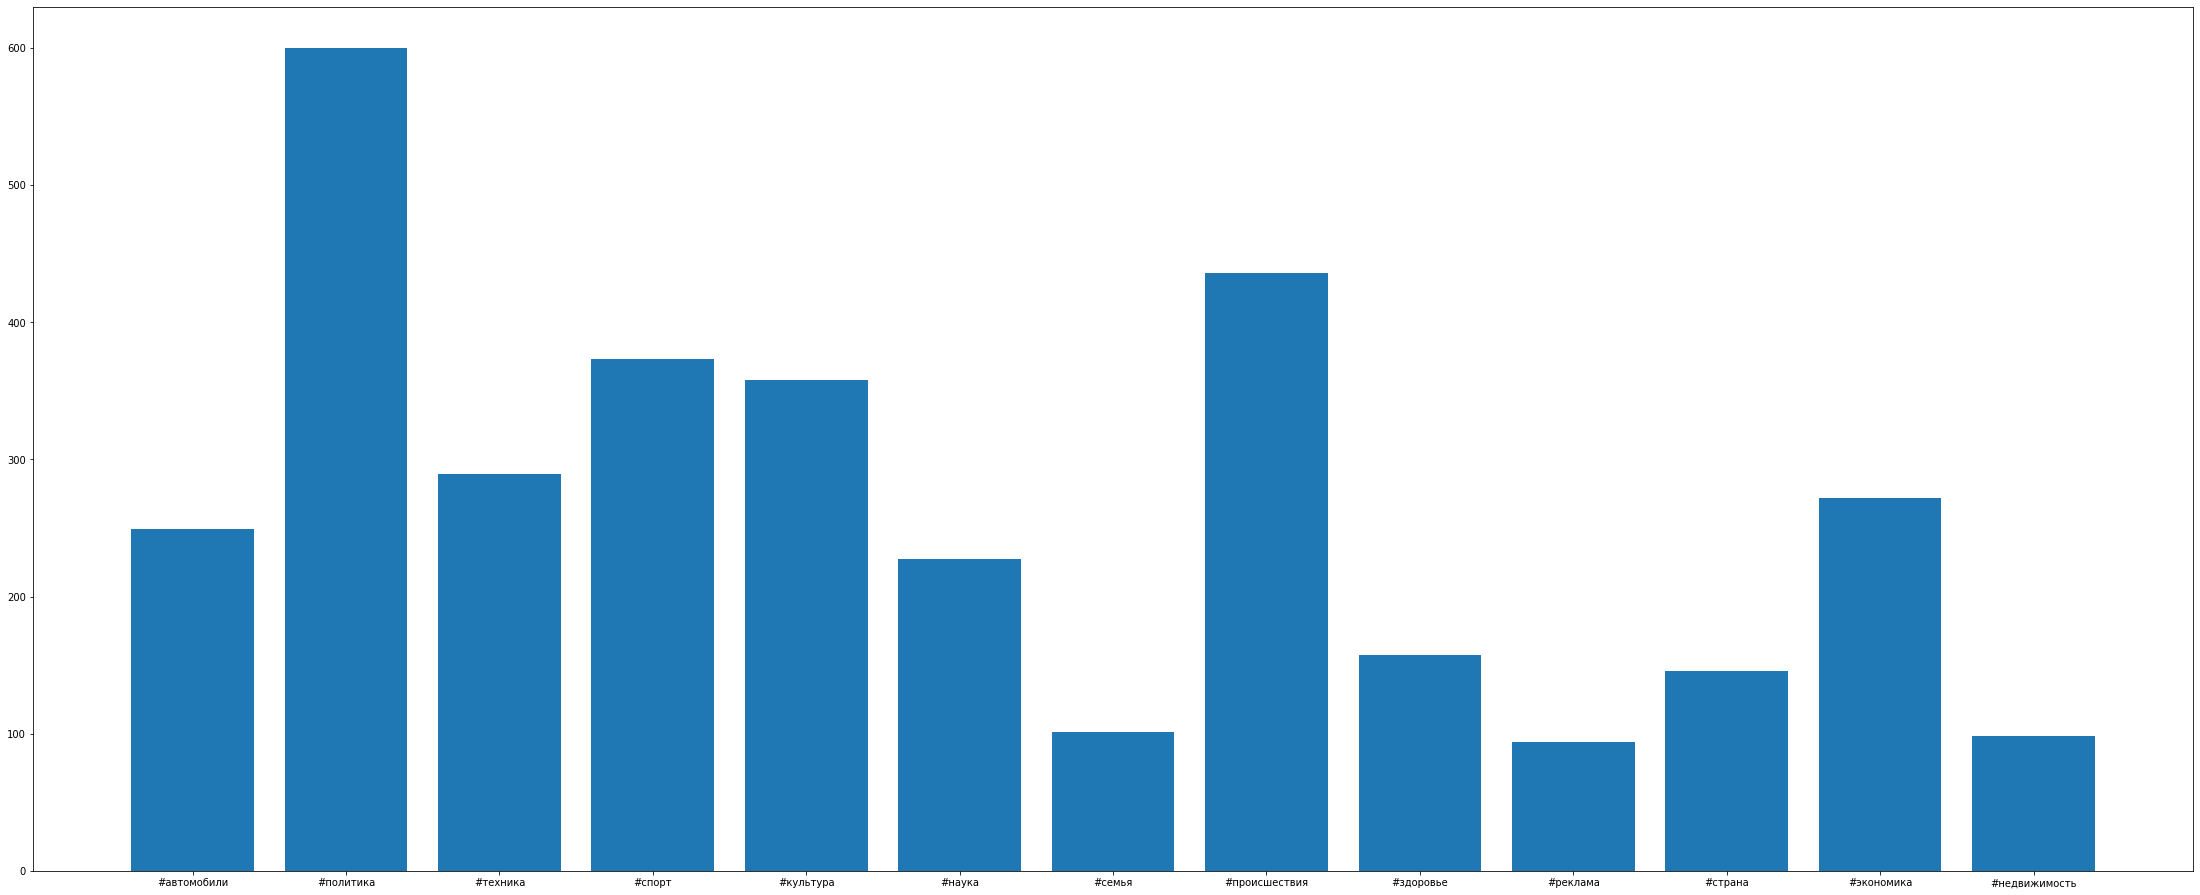

In [7]:
print(f'Всего тегов: {len(tags_set)}')
tags_list = list(tags_set)
class_count = [tags.count(tags_list[i]) for i in range(len(tags_list))]

for i, tag in enumerate(tags_list):
	print(f'Примеров в классе {tag}: {class_count[i]}')

fig = plt.figure()
ax = fig.add_axes([0,0,5,3])
ax.bar(tags_list, class_count)
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(lines, tags, test_size=0.3, random_state=42, shuffle=True)

In [9]:
%%time
russian_stopwords = stopwords.words("russian")
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words=russian_stopwords, max_features=8000)

len_trn = len(X_train)
x_t = X_train[:]
x_t.extend(X_test)

x_trn = count_vectorizer.fit_transform(x_t)

x_trn = x_trn[:len_trn]

data_features = count_vectorizer.transform(X_test)

Wall time: 11.7 s


In [10]:
feature_names = count_vectorizer.get_feature_names()
print(len(feature_names))
print(feature_names[50:90]) # вывод нектоторых слов

8000
['baikal-m', 'baleno', 'bank', 'be', 'beijing', 'belarus', 'beroc', 'best', 'bj', 'bloomberg', 'bmw', 'boeing', 'bosch', 'brent', 'brexit', 'by', 'byn', 'c', 'ca', 'camry', 'carla', 'cd', 'chanel', 'chery', 'chevrolet', 'chiesa', 'choice', 'citroen', 'class', 'club', 'cnn', 'coldplay', 'comfort', 'comics', 'composite', 'continental', 'creta', 'critics', 'cruze', 'ctrl+enter']


C:\Users\mchuv\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
%%time
logreg = LogisticRegression(n_jobs=-1, C=1e5, max_iter=200)
logreg = logreg.fit(x_trn, y_train)
predictions = logreg.predict(data_features)
print('[Train] accuracy %s' % accuracy_score(y_train, logreg.predict(x_trn)))
print('[Test] accuracy %s' % accuracy_score(y_test, predictions))

[Train] accuracy 1.0
[Test] accuracy 0.8362745098039216
Wall time: 5.45 s


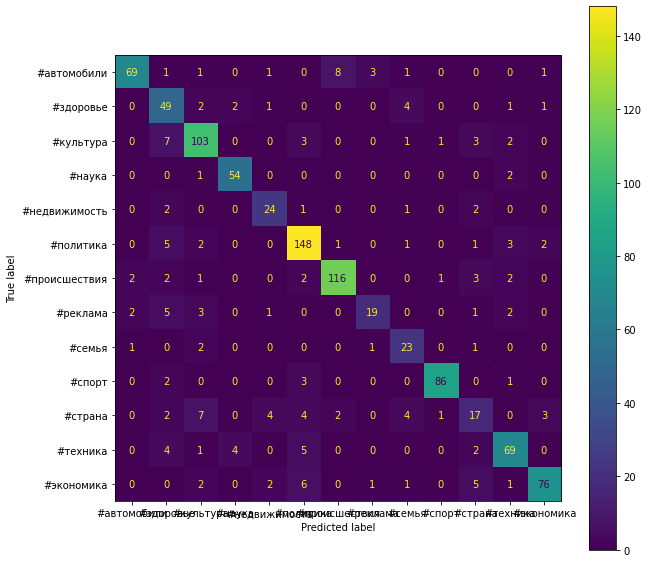

               precision    recall  f1-score   support

  #автомобили     0.9324    0.8118    0.8679        85
    #здоровье     0.6203    0.8167    0.7050        60
    #культура     0.8240    0.8583    0.8408       120
       #наука     0.9000    0.9474    0.9231        57
#недвижимость     0.7273    0.8000    0.7619        30
    #политика     0.8605    0.9080    0.8836       163
#происшествия     0.9134    0.8992    0.9063       129
     #реклама     0.7917    0.5758    0.6667        33
       #семья     0.6389    0.8214    0.7187        28
       #спорт     0.9663    0.9348    0.9503        92
      #страна     0.4857    0.3864    0.4304        44
     #техника     0.8313    0.8118    0.8214        85
   #экономика     0.9157    0.8085    0.8588        94

     accuracy                         0.8363      1020
    macro avg     0.8006    0.7985    0.7950      1020
 weighted avg     0.8408    0.8363    0.8357      1020



In [12]:
cm = confusion_matrix(y_test, predictions)
cmp = ConfusionMatrixDisplay(cm, display_labels=sorted(tags_list))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)
plt.show()

print(classification_report(y_test, predictions, digits=4))

In [19]:
def most_influential_words(vectorizer, tag_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logreg.coef_[tag_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]

In [20]:
# важные слова для тега
genre_tag_id = 0
print(logreg.classes_[genre_tag_id])
most_influential_words(count_vectorizer, genre_tag_id)

#автомобили


C:\Users\mchuv\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['автомобиль',
 'авто',
 'машина',
 'продажа',
 'модель',
 'marussia',
 'водитель',
 'дорожный',
 'гаи',
 'внедорожник']

In [21]:
%%time
doc_clf = SGDClassifier(loss = 'hinge', max_iter = 1000, tol = 1e-3)
doc_clf.fit(x_trn, y_train) # Обучение классификатора
print('Оценка точности классификации')
score = doc_clf.score(data_features, y_test)
print('Точность на проверочном множестве:', round(score, 4))
score = doc_clf.score(x_trn, y_train)
print('Точность на обучающем множестве:', round(score, 4))
predictions = doc_clf.predict(data_features)
print('accuracy %s' % accuracy_score(y_test, predictions))

Оценка точности классификации
Точность на проверочном множестве: 0.799
Точность на обучающем множестве: 0.9895
accuracy 0.7990196078431373
Wall time: 125 ms


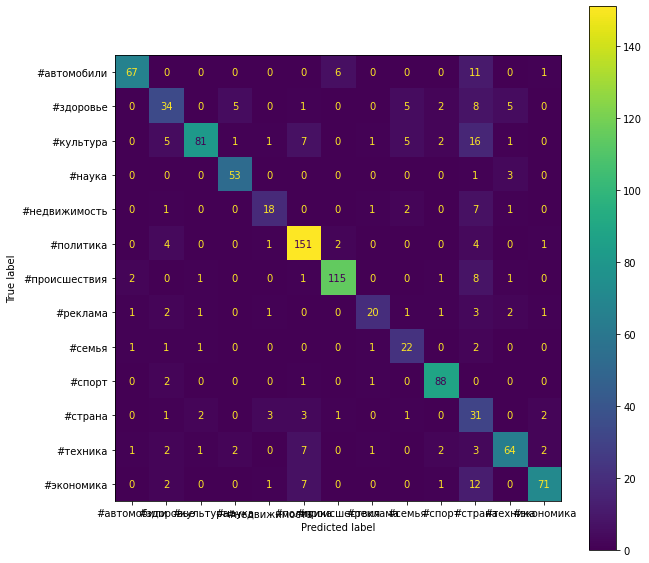

               precision    recall  f1-score   support

  #автомобили     0.9306    0.7882    0.8535        85
    #здоровье     0.6296    0.5667    0.5965        60
    #культура     0.9310    0.6750    0.7826       120
       #наука     0.8689    0.9298    0.8983        57
#недвижимость     0.7200    0.6000    0.6545        30
    #политика     0.8483    0.9264    0.8856       163
#происшествия     0.9274    0.8915    0.9091       129
     #реклама     0.8000    0.6061    0.6897        33
       #семья     0.6111    0.7857    0.6875        28
       #спорт     0.9072    0.9565    0.9312        92
      #страна     0.2925    0.7045    0.4133        44
     #техника     0.8312    0.7529    0.7901        85
   #экономика     0.9103    0.7553    0.8256        94

     accuracy                         0.7990      1020
    macro avg     0.7852    0.7645    0.7629      1020
 weighted avg     0.8370    0.7990    0.8092      1020



In [22]:
cm = confusion_matrix(y_test, predictions)
cmp = ConfusionMatrixDisplay(cm, display_labels=sorted(tags_list))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)
plt.show()

print(classification_report(y_test, predictions, digits=4))

In [23]:
%%time
doc_clf = RandomForestClassifier(n_estimators=15, n_jobs=-1)
doc_clf.fit(x_trn, y_train) # Обучение классификатора
print('Оценка точности классификации')
score = doc_clf.score(data_features, y_test)
print('Точность на проверочном множестве:', round(score, 4))
score = doc_clf.score(x_trn, y_train)
print('Точность на обучающем множестве:', round(score, 4))
predictions = doc_clf.predict(data_features)
print('accuracy %s' % accuracy_score(y_test, predictions))

Оценка точности классификации
Точность на проверочном множестве: 0.7353
Точность на обучающем множестве: 0.9987
accuracy 0.7352941176470589
Wall time: 122 ms


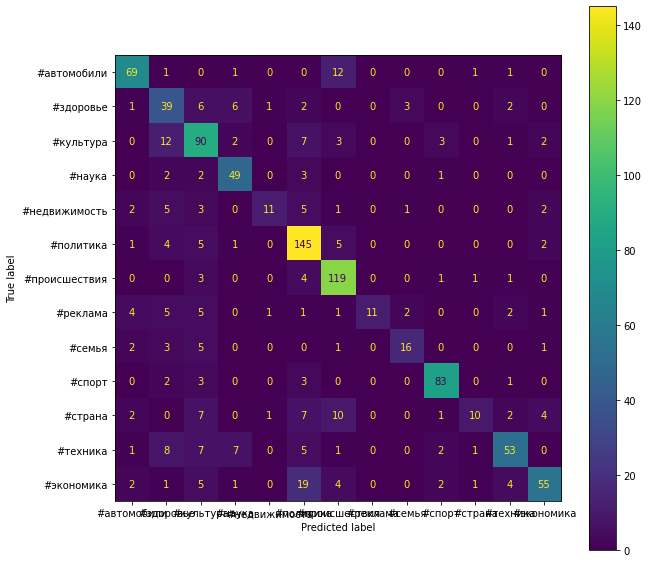

               precision    recall  f1-score   support

  #автомобили     0.8214    0.8118    0.8166        85
    #здоровье     0.4756    0.6500    0.5493        60
    #культура     0.6383    0.7500    0.6897       120
       #наука     0.7313    0.8596    0.7903        57
#недвижимость     0.7857    0.3667    0.5000        30
    #политика     0.7214    0.8896    0.7967       163
#происшествия     0.7580    0.9225    0.8322       129
     #реклама     1.0000    0.3333    0.5000        33
       #семья     0.7273    0.5714    0.6400        28
       #спорт     0.8925    0.9022    0.8973        92
      #страна     0.7143    0.2273    0.3448        44
     #техника     0.7910    0.6235    0.6974        85
   #экономика     0.8209    0.5851    0.6832        94

     accuracy                         0.7353      1020
    macro avg     0.7598    0.6533    0.6721      1020
 weighted avg     0.7518    0.7353    0.7236      1020



In [24]:
cm = confusion_matrix(y_test, predictions)
cmp = ConfusionMatrixDisplay(cm, display_labels=sorted(tags_list))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)
plt.show()

print(classification_report(y_test, predictions, digits=4))

In [34]:
print(sorted(VALID_METRICS['ball_tree']))
print(sorted(VALID_METRICS['kd_tree']))

['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'dice', 'euclidean', 'hamming', 'haversine', 'infinity', 'jaccard', 'kulsinski', 'l1', 'l2', 'mahalanobis', 'manhattan', 'matching', 'minkowski', 'p', 'pyfunc', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'wminkowski']
['chebyshev', 'cityblock', 'euclidean', 'infinity', 'l1', 'l2', 'manhattan', 'minkowski', 'p']


In [60]:
%%time
doc_clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1, algorithm='auto', metric='cosine')
doc_clf.fit(x_trn, y_train) # Обучение классификатора
print('Оценка точности классификации')
score = doc_clf.score(data_features, y_test)
print('Точность на проверочном множестве:', round(score, 4))
score = doc_clf.score(x_trn, y_train)
print('Точность на обучающем множестве:', round(score, 4))
predictions = doc_clf.predict(data_features)
print('accuracy %s' % accuracy_score(y_test, predictions))

Оценка точности классификации
Точность на проверочном множестве: 0.5451
Точность на обучающем множестве: 0.8147
accuracy 0.5450980392156862
Wall time: 491 ms


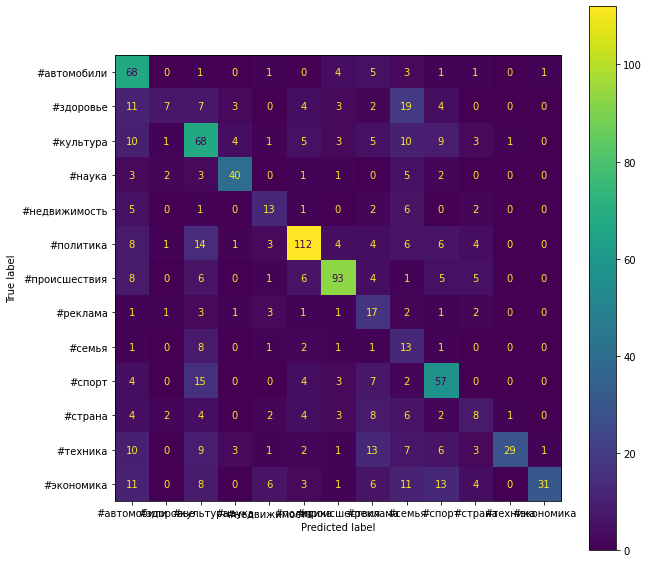

               precision    recall  f1-score   support

  #автомобили     0.4722    0.8000    0.5939        85
    #здоровье     0.5000    0.1167    0.1892        60
    #культура     0.4626    0.5667    0.5094       120
       #наука     0.7692    0.7018    0.7339        57
#недвижимость     0.4062    0.4333    0.4194        30
    #политика     0.7724    0.6871    0.7273       163
#происшествия     0.7881    0.7209    0.7530       129
     #реклама     0.2297    0.5152    0.3178        33
       #семья     0.1429    0.4643    0.2185        28
       #спорт     0.5327    0.6196    0.5729        92
      #страна     0.2500    0.1818    0.2105        44
     #техника     0.9355    0.3412    0.5000        85
   #экономика     0.9394    0.3298    0.4882        94

     accuracy                         0.5451      1020
    macro avg     0.5539    0.4983    0.4795      1020
 weighted avg     0.6359    0.5451    0.5490      1020



In [61]:
cm = confusion_matrix(y_test, predictions)
cmp = ConfusionMatrixDisplay(cm, display_labels=sorted(tags_list))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)
plt.show()

print(classification_report(y_test, predictions, digits=4))